In [58]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, f_oneway , chi2 , kruskal , t , mannwhitneyu
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import kstest
import pingouin as pg
from statsmodels.stats.multitest import multipletests

# Memory Scores

In [51]:
# Do children with neurodevelopmental disorders have lower memory scores?
data_normal = np.array([24, 22, 19, 22, 28, 26, 28, 24, 30, 29, 25, 20, 17, 19, 18, 26, 27, 24, 27, 27])
data_autistic = np.array([15, 2, 1, 21, 3, 10, 9, 8, 3, 7, 6, 18, 2, 5, 2, 5, 0, 27])
data_epilepsy = np.array([30, 15, 34, 26, 14, 28, 17, 29, 25, 11, 37, 36, 34, 22, 18, 5, 12, 10,15])

##### Null Hypothesis (H0): There is no significant difference in memory scores among children with different neurodevelopmental disorders.

##### Alternative Hypothesis (H1): Children with neurodevelopmental disorders (such as Autism and Epilepsy) have lower memory scores compared to children without these disorders.

In [52]:
group_stats = {
    'Groups': ['Normal', 'Autistic', 'Epilepsy'],
    'Count': [len(data_normal), len(data_autistic), len(data_epilepsy)],
    'Sum': [data_normal.sum(), data_autistic.sum(), data_epilepsy.sum()],
    'Average': [data_normal.mean(), data_autistic.mean(), data_epilepsy.mean()],
    'Variance': [data_normal.var(), data_autistic.var(), data_epilepsy.var()]
}
group_stats_df = pd.DataFrame(group_stats)
print(group_stats_df)

     Groups  Count  Sum  Average   Variance
0    Normal     20  482     24.1  14.390000
1  Autistic     18  144      8.0  54.333333
2  Epilepsy     19  418     22.0  91.578947


## Check for Normality

In [53]:
shapiro_normality_tests = {}
for temp_data in data_normal, data_autistic, data_epilepsy:
    stat, p = shapiro(temp_data)
    col = 'Normal' if temp_data is data_normal else 'Autistic' if temp_data is data_autistic else 'Epilepsy'
    shapiro_normality_tests[col] = {'Shapiro-Wilk Statistic': stat, 'p-value': p, 'Normality': p > 0.05}
    if p < 0.05:
        print(f"Data for {col} group is not normally distributed.")
        print("Kruskal-Wallis Test is used for non-parametric data.")

lilliefors_normality_tests = {}
for temp_data in data_normal, data_autistic, data_epilepsy:
    n = len(temp_data)
    d, p = kstest(temp_data, 'norm', args=(np.mean(temp_data), np.std(temp_data, ddof=1)))
    col = 'Normal' if temp_data is data_normal else 'Autistic' if temp_data is data_autistic else 'Epilepsy'
    lilliefors_normality_tests[col] = {'Kolmogorov-Smirnov Statistic': d, 'p-value': p, 'Normality': p > 0.05}

print("Shapiro Normality Tests:")
print(pd.DataFrame(shapiro_normality_tests))
print("\n")
print("Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:")
print(pd.DataFrame(lilliefors_normality_tests))

Data for Autistic group is not normally distributed.
Kruskal-Wallis Test is used for non-parametric data.
Shapiro Normality Tests:
                          Normal  Autistic  Epilepsy
Shapiro-Wilk Statistic  0.942034  0.856206  0.946716
p-value                 0.261899  0.010625  0.346958
Normality                   True     False      True


Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:
                                Normal  Autistic  Epilepsy
Kolmogorov-Smirnov Statistic  0.139751  0.173789  0.131621
p-value                       0.779754  0.588889  0.855336
Normality                         True      True      True


# Mann-Whitney U test

In [54]:
disorder_group = np.concatenate([data_autistic, data_epilepsy])
normal_group = data_normal

stat_normal, p_normal = shapiro(disorder_group)
print("\nShapiro-Wilk Test for Normal vs Disorder Group:")
print('Statistics=%.3f, p=%.3f' % (stat_normal, p_normal))
stat_disorder , p_disorder = shapiro(normal_group)
print('Statistics=%.3f, p=%.3f' % (stat_disorder, p_disorder))
if p_normal > 0.05 and p_disorder > 0.05:
    print("Data is normally distributed.")
    print("ANOVA test is used for parametric data.")
else:
    print("Variance is not equal.")
    print("Kruskal-Wallis Test is used for non-parametric data.")


stat, p = mannwhitneyu(disorder_group, normal_group)
print("\nMann-Whitney U Test for Normal vs Disorder Group:")
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("Failed to Reject null Hypothesis.")
else:
    print("Reject null hypothesis")


Shapiro-Wilk Test for Normal vs Disorder Group:
Statistics=0.928, p=0.020
Statistics=0.942, p=0.262
Variance is not equal.
Kruskal-Wallis Test is used for non-parametric data.

Mann-Whitney U Test for Normal vs Disorder Group:
Statistics=186.500, p=0.002
Reject null hypothesis


### Check homogeneity of variances

In [55]:
levene_mean = levene(data_normal, data_autistic, data_epilepsy, center='mean')
levene_median = levene(data_normal, data_autistic, data_epilepsy, center='median')
levene_trimmed_mean = levene(data_normal, data_autistic, data_epilepsy, center='trimmed')
print("\nHomogeneity of Variances Test:")
levene_test = pd.DataFrame({
    'Center': ['Mean', 'Median', 'Trimmed Mean'],
    'Test-Statistic': [levene_mean.statistic, levene_median.statistic, levene_trimmed_mean.statistic],
    'p-value': [levene_mean.pvalue, levene_median.pvalue, levene_trimmed_mean.pvalue]
})
print(levene_test)
if levene_mean.pvalue > 0.05:
    print("Variance is homogenous based on mean")
elif levene_median.pvalue > 0.05:
    print("Variance is homogenous based on median")
elif levene_trimmed_mean.pvalue > 0.05:
    print("Variance is homogenous based on trimmed mean")
else:
    print("Variance is not homogenous")


Homogeneity of Variances Test:
         Center  Test-Statistic   p-value
0          Mean        9.114628  0.000388
1        Median        7.490140  0.001346
2  Trimmed Mean        9.811781  0.000242
Variance is not homogenous


### Since , normality is not satisfied, we will use the Kruskal-Wallis test to check for significant differences in memory scores among children with different neurodevelopmental disorders.

## Kruskal-Wallis Test

In [57]:
kruskal_test = kruskal(data_normal, data_autistic, data_epilepsy)
print("\nKruskal-Wallis Test:")
print(f"Test-Statistic: {kruskal_test.statistic}")
print(f"p-value: {kruskal_test.pvalue}")
print("Since the data were not normally distributed, Kruskal-Wallis test for non-parametric data was used to evaluate differences among the three groups.")

alpha = 0.05
df = 2
H_critical = chi2.ppf(1 - alpha, df)
print("\nChi-square Critical Value:")
print(f"H-critical value: {H_critical}")

if kruskal_test.statistic > H_critical:
    print("There is a significant difference between groups. Reject the null hypothesis.")
else:
    print("There is no significant difference between groups. Fail to reject the null hypothesis.")



Kruskal-Wallis Test:
Test-Statistic: 24.96372784522497
p-value: 3.7948566447011024e-06
Since the data were not normally distributed, Kruskal-Wallis test for non-parametric data was used to evaluate differences among the three groups.

Chi-square Critical Value:
H-critical value: 5.991464547107979
There is a significant difference between groups. Reject the null hypothesis.


In [60]:
datasets = [('Normal', data_normal), ('Autistic', data_autistic), ('Epilepsy', data_epilepsy)]
alpha = 0.05
p_values = []
for i in range(len(datasets)):
    for j in range(i + 1, len(datasets)):
        group1_name, group1_data = datasets[i]
        group2_name, group2_data = datasets[j]
        t_stat, p_value = ttest_ind(group1_data, group2_data)
        p_values.append(p_value)

reject, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')
index = 0
for i in range(len(datasets)):
    for j in range(i + 1, len(datasets)):
        group1_name, _ = datasets[i]
        group2_name, _ = datasets[j]
        if reject[index]:
            print(f"There is a significant difference between {group1_name} and {group2_name} (p-corrected = {p_values_corrected[index]})")
        else:
            print(f"No significant difference between {group1_name} and {group2_name} (p-corrected = {p_values_corrected[index]})")
        index += 1

There is a significant difference between Normal and Autistic (p-corrected = 1.7871272588070343e-09)
No significant difference between Normal and Epilepsy (p-corrected = 1.0)
There is a significant difference between Autistic and Epilepsy (p-corrected = 8.034033246856018e-05)


# Games-Howell Post-Hoc Test

In [8]:
def games_howell(data1, data2):
    n1 = len(data1)
    n2 = len(data2)
    var1 = np.var(data1, ddof=1)
    var2 = np.var(data2, ddof=1)
    df_num = (var1 / n1 + var2 / n2)**2
    df_denom = (var1**2 / ((n1**2) * (n1 - 1)) + var2**2 / ((n2**2) * (n2 - 1)))
    df = df_num / df_denom
    t_stat = (np.mean(data1) - np.mean(data2)) / np.sqrt(var1 / n1 + var2 / n2)
    p_value = 2 * t.cdf(-np.abs(t_stat), df)
    return t_stat, p_value

t_stats = {}
p_values = {}
groups = ['Normal', 'Autistic', 'Epilepsy']
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = globals()['data_' + groups[i].lower()]
        group2 = globals()['data_' + groups[j].lower()]
        t_stat, p_value = games_howell(group1, group2)
        t_stats[(groups[i], groups[j])] = t_stat
        p_values[(groups[i], groups[j])] = p_value

print("Games-Howell Test Results:")
print("Pairwise Comparisons\t| t-statistic\t| p-value")
print("---------------------------------------------")
for (group1, group2), t_stat in t_stats.items():
    print(f"{group1} vs {group2}\t\t| {t_stat:.6f}\t| {p_values[(group1, group2)]:.6f}")

if all(p > 0.05 for p in p_values.values()):
    print("There is no significant difference between the groups. Fail to reject the null hypothesis.")
else:
    print("There is a significant difference between the groups. Reject the null hypothesis.")


data_disorder = np.concatenate((data_autistic, data_epilepsy))
t_stat , p = games_howell(data_normal, data_disorder)
print("\nNormal vs Disorder:")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p}")
if p < 0.05:
    print("There is a significant difference between the groups. Reject the null hypothesis.")
else:
    print("There is no significant difference between the groups. Fail to reject the null hypothesis.")

Games-Howell Test Results:
Pairwise Comparisons	| t-statistic	| p-value
---------------------------------------------
Normal vs Autistic		| 8.097257	| 0.000000
Normal vs Epilepsy		| 0.868608	| 0.393932
Autistic vs Epilepsy		| -4.864221	| 0.000026
There is a significant difference between the groups. Reject the null hypothesis.

Normal vs Disorder:
t-statistic: 4.36992145838539
p-value: 6.412124359365507e-05
There is a significant difference between the groups. Reject the null hypothesis.


# Plot Analysed data

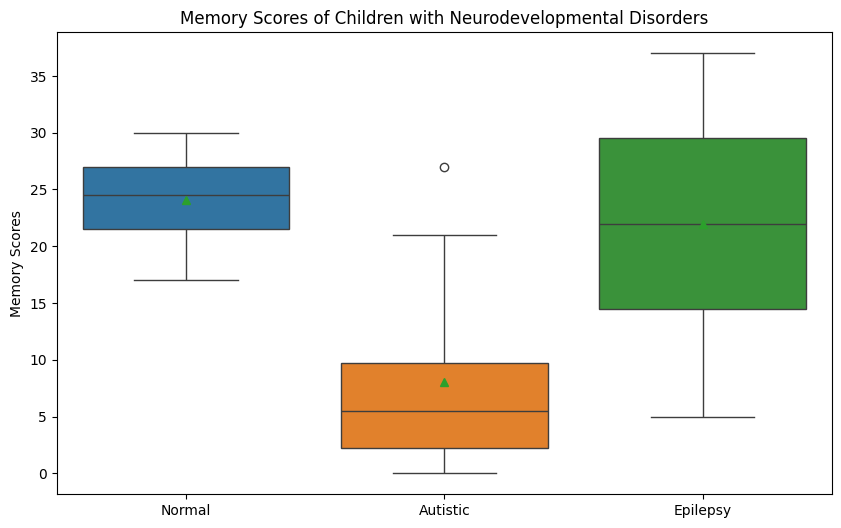

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[data_normal, data_autistic, data_epilepsy], showmeans=True)
plt.xticks(ticks=[0, 1, 2], labels=['Normal', 'Autistic', 'Epilepsy'])
plt.ylabel('Memory Scores')
plt.title('Memory Scores of Children with Neurodevelopmental Disorders')
plt.show()

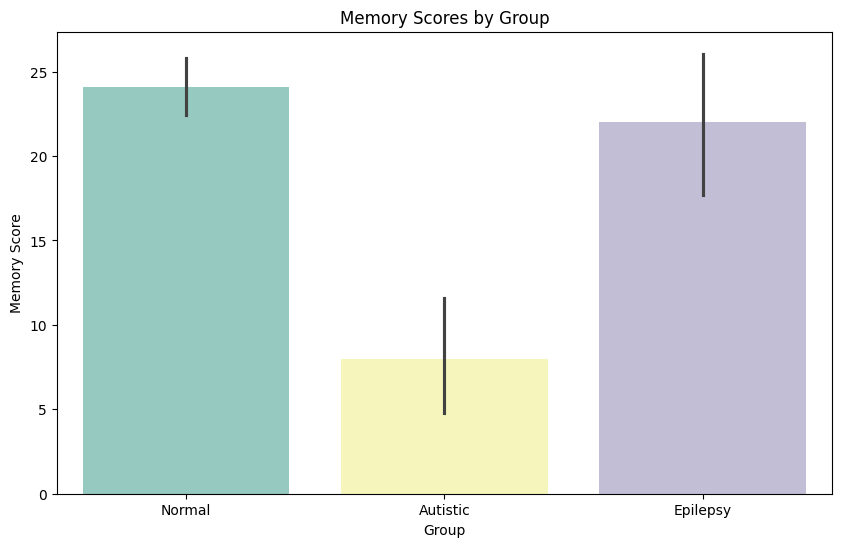

Error bars denote confidence intervals (CI) of 95%


In [20]:
groups = ['Normal'] * len(data_normal) + ['Autistic'] * len(data_autistic) + ['Epilepsy'] * len(data_epilepsy)
exam_scores = np.concatenate([data_normal, data_autistic, data_epilepsy])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=groups, y=exam_scores, errorbar=('ci', 95), palette="Set3" , hue=groups)
plt.title('Memory Scores by Group')
plt.xlabel('Group')
plt.ylabel('Memory Score')
plt.show()
print("Error bars denote confidence intervals (CI) of 95%")

# Driving Scores

In [4]:
## What extent of sleep deprivation affects driving ability ? 
## Condition 1 - same people in all 3 groups
## Condition 2 - different people in all 3 groups
one_night = np.array([15, 18, 20, 15, 12, 18, 16, 17, 14, 19, 20, 15, 16, 18, 19, 15, 17, 18, 17, 16])
two_night = np.array([10, 16, 13, 11, 9, 14, 13, 14, 15, 14, 12, 13, 14, 12, 11, 15, 14, 16, 12, 13])
three_night = np.array([5, 3, 9, 6, 4, 7, 8, 2, 4, 6, 9, 5, 3, 7, 1, 8, 7, 3, 6, 4])

In [6]:
group_stats = {
    'Groups': ['One-Night', 'Two-Night', 'Three-Night'],
    'Count': [len(one_night), len(two_night), len(three_night)],
    'Sum': [one_night.sum(), two_night.sum(), three_night.sum()],
    'Average': [one_night.mean(), two_night.mean(), three_night.mean()],
    'Variance': [one_night.var(), two_night.var(), three_night.var()]
}
group_stats_df = pd.DataFrame(group_stats) 
print(group_stats_df)

        Groups  Count  Sum  Average  Variance
0    One-Night     20  335    16.75    4.0875
1    Two-Night     20  261    13.05    3.3475
2  Three-Night     20  107     5.35    5.1275


#### Null Hypothesis (H0): There is no significant difference in driving scores among individuals experiencing different durations of sleep deprivation.

#### Alternative Hypothesis (H1): There is a significant difference in driving scores among individuals experiencing different durations of sleep deprivation.

## Check for Normality

In [8]:
shapiro_normality_tests = {}
for temp_data in one_night, two_night, three_night:
    stat, p = shapiro(temp_data)
    col = 'One-Night' if temp_data is one_night else 'Two-Night' if temp_data is two_night else 'Three-Night'
    shapiro_normality_tests[col] = {'Shapiro-Wilk Statistic': stat, 'p-value': p, 'Normality': p > 0.05}
    if p < 0.05:
        print(f"Data for {col} group is not normally distributed.")
        print("Kruskal-Wallis Test is used for non-parametric data.")

lilliefors_normality_tests = {}
for temp_data in one_night, two_night, three_night:
    n = len(temp_data)
    d, p = kstest(temp_data, 'norm', args=(np.mean(temp_data), np.std(temp_data, ddof=1)))
    col = 'One-Night' if temp_data is one_night else 'Two-Night' if temp_data is two_night else 'Three-Night'
    lilliefors_normality_tests[col] = {'Kolmogorov-Smirnov Statistic': d, 'p-value': p, 'Normality': p > 0.05}

print("Shapiro Normality Tests:")
print(pd.DataFrame(shapiro_normality_tests))
print("\n")
print("Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:")
print(pd.DataFrame(lilliefors_normality_tests))

Shapiro Normality Tests:
                       One-Night Two-Night Three-Night
Shapiro-Wilk Statistic  0.961926  0.960936    0.963007
p-value                    0.583   0.56272    0.605514
Normality                   True      True        True


Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:
                             One-Night Two-Night Three-Night
Kolmogorov-Smirnov Statistic  0.126619  0.143602     0.11941
p-value                       0.866363   0.75198    0.906136
Normality                         True      True        True


### Check homogeneity of variances

In [33]:
levene_mean = levene(one_night, two_night, three_night, center='mean')
levene_median = levene(one_night, two_night, three_night, center='median')
levene_trimmed_mean = levene(one_night, two_night, three_night, center='trimmed')
print("\nHomogeneity of Variances Test:")
levene_test = pd.DataFrame({
    'Center': ['Mean', 'Median', 'Trimmed Mean'],
    'Test-Statistic': [levene_mean.statistic, levene_median.statistic, levene_trimmed_mean.statistic],
    'p-value': [levene_mean.pvalue, levene_median.pvalue, levene_trimmed_mean.pvalue]
})
print(levene_test)
if levene_mean.pvalue > 0.05:
    print("Variance is homogenous based on mean")
elif levene_median.pvalue > 0.05:
    print("Variance is homogenous based on median")
elif levene_trimmed_mean.pvalue > 0.05:
    print("Variance is homogenous based on trimmed mean")
else:
    print("Variance is not homogenous")


Homogeneity of Variances Test:
         Center  Test-Statistic   p-value
0          Mean        0.913645  0.406852
1        Median        0.897452  0.413288
2  Trimmed Mean        1.273181  0.288686
Variance is homogenous based on mean


### Check for sphericity of variances

In [38]:
data = pd.DataFrame({
    'One-Night': one_night,
    'Two-Night': two_night,
    'Three-Night': three_night
})
mauchly_test = pg.sphericity(data)
print(mauchly_test)
print("Mauchly's Sphericity Test:")
if mauchly_test[1] > 0.05:
    print("Sphericity assumption is met.")
    print("Repeated Measures ANOVA test is used for parametric data.")
else:
    print("Sphericity assumption is not met.")
    print("Friedman Test is used for non-parametric data.")

SpherResults(spher=True, W=0.9171200343766543, chi2=1.5573044933841214, dof=2, pval=0.45902424604371417)
Mauchly's Sphericity Test:
Sphericity assumption is met.
Repeated Measures ANOVA test is used for parametric data.


# Condition 1 - Same people in all 3 groups

In [39]:
repeated_anova = pg.rm_anova(data=pd.DataFrame({'One-Night': one_night, 'Two-Night': two_night, 'Three-Night': three_night}))
print("Repeated Measures ANOVA Test:")
print(repeated_anova)
p_value = repeated_anova['p-unc'][0]
f_stat = repeated_anova['F'][0]
 
data_long = pd.melt(data.reset_index(), id_vars=['index'], value_vars=['One-Night', 'Two-Night', 'Three-Night'])
data_long.columns = ['Subject', 'Night', 'Score']
rm_anova = AnovaRM(data_long, 'Score', 'Subject', within=['Night']).fit()
print("\nRepeated Measures ANOVA Test:")
print(rm_anova.summary())

if p_value < 0.05:
    print("There is a significant difference between the groups.")
    print("Main effect (F) is significant.")
else:
    print("There is no significant difference between the groups.")
    print("Main effect (F) is not significant. No post-hoc test performed.")

Repeated Measures ANOVA Test:
   Source  ddof1  ddof2           F         p-unc       ng2       eps
0  Within      2     38  178.017544  5.020250e-20  0.843378  0.923463

Repeated Measures ANOVA Test:
               Anova
      F Value  Num DF  Den DF Pr > F
------------------------------------
Night 178.0175 2.0000 38.0000 0.0000

There is a significant difference between the groups.
Main effect (F) is significant.


# Condition 2 - Different people in all 3 groups

In [44]:
k = 3
N = len(one_night) + len(two_night) + len(three_night)
group_means = [np.mean(one_night), np.mean(two_night), np.mean(three_night)]
grand_mean = np.mean([np.mean(one_night), np.mean(two_night), np.mean(three_night)])
SSb = sum([len(one_night) * (group_means[0] - grand_mean) ** 2,
           len(two_night) * (group_means[1] - grand_mean) ** 2,
           len(three_night) * (group_means[2] - grand_mean) ** 2])
dfb = k-1
MSb = SSb / dfb
SSw = sum([(x - group_means[i]) ** 2 for i, data in enumerate([one_night,two_night,three_night]) for x in data])
dfw = N-k
MSw = SSw / dfw
F_value = MSb / MSw
alpha = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)
p_value = 1-f.cdf(F_value, dfb, dfw)


anova_table = [
    ["Between Groups", f"{SSb:.6f}", dfb, f"{MSb:.6f}", f"{F_value:.6f}",f"{p_value}" ,f"{F_crit:.6f}"],
    ["Within Groups", f"{SSw:.6f}", dfw, f"{MSw:.6f}"],
    ["Total", f"{SSb+SSw:.6f}", dfb+dfw]
]

print("ANOVA Table")
print(tabulate(anova_table, headers=["Source of Variation", "SS", "df", "MS", "F", "p-value","F crit"], tablefmt="pretty"))

ANOVA Table
+---------------------+-------------+----+------------+------------+------------------------+----------+
| Source of Variation |     SS      | df |     MS     |     F      |        p-value         |  F crit  |
+---------------------+-------------+----+------------+------------+------------------------+----------+
|   Between Groups    | 1352.933333 | 2  | 676.466667 | 153.467065 | 1.1102230246251565e-16 | 3.158843 |
|    Within Groups    | 251.250000  | 57 |  4.407895  |            |                        |          |
|        Total        | 1604.183333 | 59 |            |            |                        |          |
+---------------------+-------------+----+------------+------------+------------------------+----------+


In [45]:
anova_result = f_oneway(one_night, two_night, three_night)
print("\nOne-way ANOVA Test:")
print(f"F-statistic: {anova_result.statistic}")
print(f"p-value: {anova_result.pvalue}")

if anova_result.pvalue < 0.05:
    print("\nSince p-value < 0.05, there are significant differences between groups. Using a one way ANOVA we observed that the extent of sleep deprivation affects driving ability.")
else:
    print("\nNo significant differences between groups.")


One-way ANOVA Test:
F-statistic: 153.46706467661707
p-value: 1.1305349928649485e-23

Since p-value < 0.05, there are significant differences between groups. Using a one way ANOVA we observed that the schooling method has a significant effect on exam  performance


In [46]:
Effect_size = SSb / (SSb + SSw)
print(f"Effect Size: {Effect_size:.6f}")
print(f"Extent of sleep deprivation explains {Effect_size:.6f} of the variance in driving ability.")

Effect Size: 0.843378
Extent of sleep deprivation explains 0.843378 of the variance in driving ability.


In [47]:
t_statistic_one_two, p_value_one_two = ttest_ind(one_night, two_night)
t_statistic_two_three, p_value_two_three = ttest_ind(two_night, three_night)
t_statistic_three_one, p_value_three_one = ttest_ind(three_night, one_night)

alpha = 0.05
alpha_corrected = alpha / 3 

print("alpha corrected: ", alpha_corrected)

p_value_one_two_corrected = p_value_one_two * 3
p_value_two_three_corrected = p_value_two_three * 3
p_value_three_one_corrected = p_value_three_one * 3

table_data = [
    ['Groupwise comparisons', 'T-test p-value', 'Bonferroni-corrected p-value'],
    ['Home vs Boarding', p_value_one_two, p_value_one_two_corrected],
    ['Boarding vs Regular', p_value_two_three, p_value_two_three_corrected],
    ['Regular vs Home', p_value_three_one, p_value_three_one_corrected]
]
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

alpha corrected:  0.016666666666666666
+-------------------------+------------------+--------------------------------+
| Groupwise comparisons   |   T-test p-value |   Bonferroni-corrected p-value |
+=========================+==================+================================+
| Home vs Boarding        |      7.45169e-07 |                    2.23551e-06 |
+-------------------------+------------------+--------------------------------+
| Boarding vs Regular     |      5.66876e-14 |                    1.70063e-13 |
+-------------------------+------------------+--------------------------------+
| Regular vs Home         |      8.40921e-19 |                    2.52276e-18 |
+-------------------------+------------------+--------------------------------+


In [48]:
if anova_result.pvalue < 0.05:
    data_melted = pd.melt(data)
    posthoc = pairwise_tukeyhsd(data_melted['value'], data_melted['variable'], alpha=0.05)
    print(posthoc)
    print(posthoc.q_crit) 
    HSD = posthoc.q_crit*np.sqrt(MSw / len(data))
    print(f"HSD: {HSD:.6f}")
    print(f"The mean difference between any two samples must be more than {HSD:.6f} at alpha = 0.05 for the difference to be statistically significant")

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj  lower    upper  reject
--------------------------------------------------------------
  One-Night Three-Night    -11.4   0.0 -12.9977 -9.8023   True
  One-Night   Two-Night     -3.7   0.0  -5.2977 -2.1023   True
Three-Night   Two-Night      7.7   0.0   6.1023  9.2977   True
--------------------------------------------------------------
3.403189192594075
HSD: 1.597669
The mean difference between any two samples must be more than 1.597669 at alpha = 0.05 for the difference to be statistically significant


In [49]:
effect_size = anova_result.statistic / (anova_result.statistic + (len(data) - 1))
print("\nEffect Size (Eta-squared):", effect_size)


Effect Size (Eta-squared): 0.8898340385416439
